In [1]:
from __future__ import  absolute_import
# though cupy is not used but without this line, it raise errors...
import cupy as cp
import os

import ipdb
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import visdom

from utils.config import opt
from data.dataset import Dataset, TestDataset, inverse_normalize
from model import FasterRCNNVGG16
from torch.utils import data as data_
from trainer import FasterRCNNTrainer
from utils import array_tool as at
from utils.vis_tool import visdom_bbox, vis_bbox
from utils.eval_tool import eval_detection_voc

# fix for ulimit
# https://github.com/pytorch/pytorch/issues/973#issuecomment-346405667
import resource

rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (20480, rlimit[1]))

/datasets/home/85/285/ktl014/simple-faster-rcnn-pytorch/model/utils/nms/non_maximum_suppression.py:12: UserWarning: 
    the python code for non_maximum_suppression is about 2x slow
    It is strongly recommended to build cython code: 
    `cd model/utils/nms/; python3 build.py build_ext --inplace
  `cd model/utils/nms/; python3 build.py build_ext --inplace''')
/datasets/home/85/285/ktl014/simple-faster-rcnn-pytorch/utils/vis_tool.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.6/si

In [2]:
def eval(dataloader, faster_rcnn, test_num=10000):
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader)):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, gt_difficults,
        use_07_metric=True)
    return result

In [3]:
def train(**kwargs):
    opt._parse(kwargs)
    return opt
opt = train()

======user config========
{'caffe_pretrain': False,
 'caffe_pretrain_path': 'checkpoints/vgg16_caffe.pth',
 'data': 'voc',
 'debug_file': '/tmp/debugf',
 'env': 'faster-rcnn',
 'epoch': 1,
 'load_path': None,
 'lr': 0.001,
 'lr_decay': 0.1,
 'max_size': 1000,
 'min_size': 600,
 'num_workers': 8,
 'plot_every': 40,
 'port': 8097,
 'pretrained_model': 'vgg16',
 'roi_sigma': 1.0,
 'rpn_sigma': 3.0,
 'test_num': 10000,
 'test_num_workers': 8,
 'use_adam': False,
 'use_chainer': False,
 'use_drop': False,
 'voc_data_dir': '/datasets/home/85/285/ktl014/simple-faster-rcnn-pytorch/dataset/VOCdevkit/VOC2007/',
 'weight_decay': 0.0005}
==========end============


In [4]:
dataset = Dataset(opt)
print('load data')
dataloader = data_.DataLoader(dataset, \
                              batch_size=1, \
                              shuffle=True, \
                              # pin_memory=True,
                              num_workers=opt.num_workers)
testset = TestDataset(opt)
test_dataloader = data_.DataLoader(testset,
                                   batch_size=1,
                                   num_workers=opt.test_num_workers,
                                   shuffle=False, \
                                   pin_memory=True
                                   )
faster_rcnn = FasterRCNNVGG16()
print('model construct completed')
trainer = FasterRCNNTrainer(faster_rcnn).cuda()
best_map = 0
lr_ = opt.lr

load data


Without the incoming socket you cannot receive events from the server or register event handlers to your Visdom client.


model construct completed


In [5]:
# Single batch
img, bbox_, label_, scale = next(iter(dataloader))
scale = at.scalar(scale)
img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
trainer.train_step(img, bbox, label, scale)

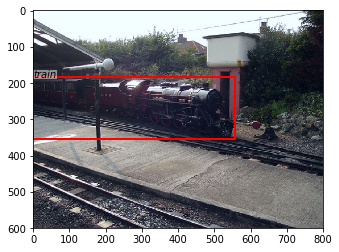

In [24]:
ori_img_ = inverse_normalize(at.tonumpy(img[0]))
gt_img = vis_bbox(ori_img_,
                     at.tonumpy(bbox_[0]),
                     at.tonumpy(label_[0]))
plt.show()

999it [08:43,  1.91it/s]

{'rpn_loc_loss': 0.0770820922185666, 'rpn_cls_loss': 0.23653538651019312, 'roi_loc_loss': 0.38138604808291143, 'roi_cls_loss': 0.5224882453773165, 'total_loss': 1.2174917729944}


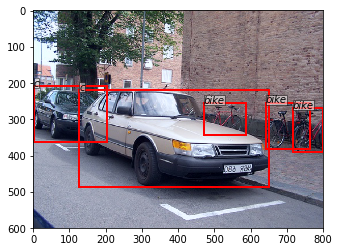

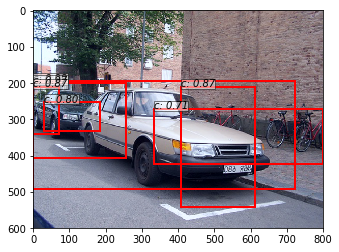

1999it [17:35,  1.89it/s]

{'rpn_loc_loss': 0.07219341246678952, 'rpn_cls_loss': 0.20917389676580203, 'roi_loc_loss': 0.38170017897471287, 'roi_cls_loss': 0.4449484109263858, 'total_loss': 1.1080158980861305}


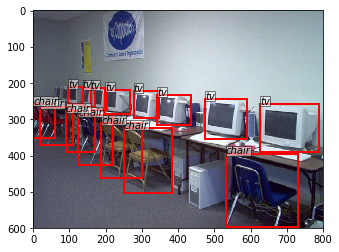

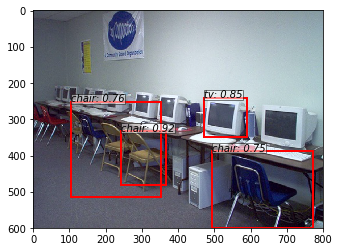

2999it [26:25,  1.89it/s]

{'rpn_loc_loss': 0.0686266404547494, 'rpn_cls_loss': 0.1963778355593485, 'roi_loc_loss': 0.37480369199047303, 'roi_cls_loss': 0.4060477065723389, 'total_loss': 1.0458558738057835}


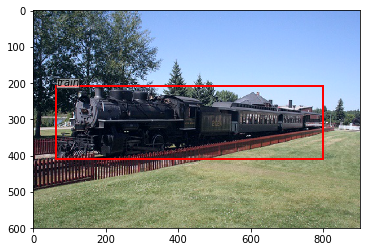

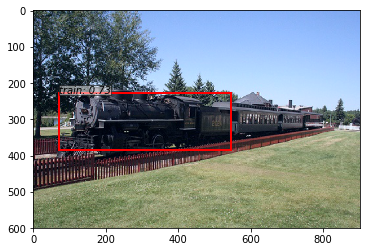

3999it [35:15,  1.89it/s]

{'rpn_loc_loss': 0.06686942179567973, 'rpn_cls_loss': 0.18721949457144355, 'roi_loc_loss': 0.3703702601497296, 'roi_cls_loss': 0.3872130618426017, 'total_loss': 1.0116722380165049}


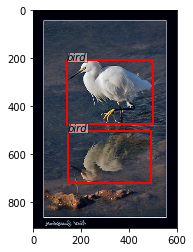

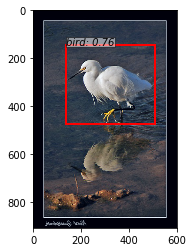

4999it [44:00,  1.89it/s]

{'rpn_loc_loss': 0.06447367298788159, 'rpn_cls_loss': 0.18040423192866145, 'roi_loc_loss': 0.36288604494092974, 'roi_cls_loss': 0.3721853127811104, 'total_loss': 0.9799492623537797}


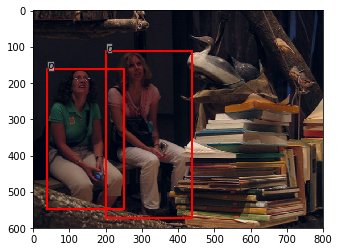

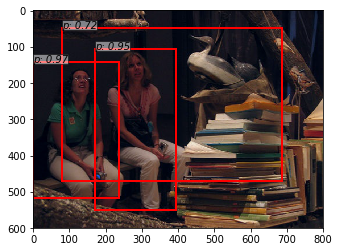

5011it [44:07,  1.89it/s]
1000it [05:52,  2.84it/s]

In [5]:
for epoch in range(opt.epoch):
    trainer.reset_meters()
    for ii, (img, bbox_, label_, scale) in tqdm(enumerate(dataloader)):
        scale = at.scalar(scale)
        img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
        trainer.train_step(img, bbox, label, scale)

        if (ii + 1) % 1000 == 0:
            print(trainer.get_meter_data())
            ori_img_ = inverse_normalize(at.tonumpy(img[0]))
            gt_img = vis_bbox(ori_img_,
                                 at.tonumpy(bbox_[0]),
                                 at.tonumpy(label_[0]))
            plt.show()

            # plot predicti bboxes
            _bboxes, _labels, _scores = trainer.faster_rcnn.predict([ori_img_], visualize=True)
            pred_img = vis_bbox(ori_img_,
                                   at.tonumpy(_bboxes[0]),
                                   at.tonumpy(_labels[0]).reshape(-1),
                                   at.tonumpy(_scores[0]))
            plt.show()
            
            
    eval_result = eval(test_dataloader, faster_rcnn, test_num=1000)
    lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
    log_info = 'lr:{}, map:{},loss:{}'.format(str(lr_), str(eval_result['map']),
                                                      str(trainer.get_meter_data()))

    if eval_result['map'] > best_map:
        best_map = eval_result['map']
        best_path = trainer.save(best_map=best_map)
    if epoch == 9:
        trainer.load(best_path)
        trainer.faster_rcnn.scale_lr(opt.lr_decay)
        lr_ = lr_ * opt.lr_decay

    if epoch == 13: 
        break
        

In [9]:
eval_result = eval(test_dataloader, faster_rcnn, test_num=100)
lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
log_info = 'lr:{}, map:{},loss:{}'.format(str(lr_), str(eval_result['map']),
                                                  str(trainer.get_meter_data()))

if eval_result['map'] > best_map:
    best_map = eval_result['map']
    best_path = trainer.save(best_map=best_map)
if epoch == 9:
    trainer.load(best_path)
    trainer.faster_rcnn.scale_lr(opt.lr_decay)
    lr_ = lr_ * opt.lr_decay

100it [00:36,  2.77it/s]

NameError: name 'epoch' is not defined

In [11]:
print(log_info)

lr:0.001, map:0.47826288783812787,loss:{'rpn_loc_loss': 0.064478582827022, 'rpn_cls_loss': 0.17955750928700265, 'roi_loc_loss': 0.3624453095047117, 'roi_cls_loss': 0.3703646318211248, 'total_loss': 0.9768460336615438}


In [12]:
trainer.get_meter_data()

{'roi_cls_loss': 0.3703646318211248,
 'roi_loc_loss': 0.3624453095047117,
 'rpn_cls_loss': 0.17955750928700265,
 'rpn_loc_loss': 0.064478582827022,
 'total_loss': 0.9768460336615438}